# Markov Chain for Campaign Attribution POC

In [29]:
import mta
import pandas as pd
import os
import numpy as np
import time
# if you haven't alreadya GCP authenticated run !gcloud auth login
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

Information about MTA module  
https://bitbucket.org/wx_rds/mta/src/50cd3c3f2469/?at=master  
https://bytebucket.org/wx_rds/mta/wiki/_build/latex/mta.pdf?token=ed3f93f21d7e08c5a92ba0abba35888f63412a54&rev=599fd6872540e9a4945b968e0f02a87c9fc15ea5  
https://www.channelattribution.net/assets/files/ChannelAttributionWhitePaper-0536c269c4725179d4a0d8b8ec2f0fac.pdf

## MC POC data

In [30]:
df = pd.read_csv('gs://wx-personal/AndrewLau/nash/MC_POC/MC_input_with_act_redemp.csv')
df = df.sample(n=100_000, random_state=123)  # random sample for testing
df.loc[:, "Converted_weighted_constant"] = round(np.maximum(0, df['inc_sales'] + 500), 0)
df.loc[:, "Converted_weighted_constant"] = df.loc[:, "Converted_weighted_constant"].fillna(0).astype("int64")
df

wk_start_date                  crn   inc_sales  \
536432    2021-02-08  1100000000054932982         NaN   
513369    2021-02-08  1100000000039184696         NaN   
951290    2021-02-08  3300000000004169326   -4.181564   
687470    2021-02-08  1100000000093580790         NaN   
599003    2021-02-08  1100000000083301004         NaN   
...              ...                  ...         ...   
444608    2021-02-08  1100000000006292146         NaN   
361016    2021-02-08  1100000000002153169         NaN   
609671    2021-02-08  1100000000083599906         NaN   
377939    2021-02-08  1100000000002553461 -115.410909   
798701    2021-02-08  1100000000121074438         NaN   

                                                     path  \
536432                                CAT-4031_email_open   
513369  CAT-4031_email/social/rapp_activation > CAT-41...   
951290  CAT-4031_email/social/rapp_activation > CVM-00...   
687470  CAT-4105_email_open > CAT-4105_rw_app_imp > CA...   
599003          CAT-4031_rw_app_imp > CAT-4031_email_open   
...                                                   ...   
444608                                CAT-4031_email_open   
361016              CAT-4105_email/social/rapp_activation   
609671  CAT-4105_email/social/rapp_activation > CAT-40...   
377939  CAT-4105_email/social/rapp_redemption > CAT-41...   
798701              CAT-4031_email/social/rapp_activation   

                                                    Paths  Converted  \
536432                 start > CAT-4031_email_open > null          0   
513369  start > CAT-4031_email/social/rapp_activation ...          0   
951290  start > CAT-4031_email/social/rapp_activation ...          0   
687470  start > CAT-4105_email_open > CAT-4105_rw_app_...          0   
599003  start > CAT-4031_rw_app_imp > CAT-4031_email_o...          0   
...                                                   ...        ...   
444608                 start > CAT-4031_email_open > null          0   
361016  start > CAT-4105_email/social/rapp_activation ...          0   
609671  start > CAT-4105_email/social/rapp_activation ...          0   
377939  start > CAT-4105_email/social/rapp_redemption ...          0   
798701  start > CAT-4031_email/social/rapp_activation ...          0   

        Converted_weighted  Converted_weighted_constant  
536432                   0                            0  
513369                   0                            0  
951290                   0                          496  
687470                   0                            0  
599003                   0                            0  
...                    ...                          ...  
444608                   0                            0  
361016                   0                            0  
609671                   0                            0  
377939                   0                          385  
798701                   0                            0  

[100000 rows x 8 columns]

<AxesSubplot:>

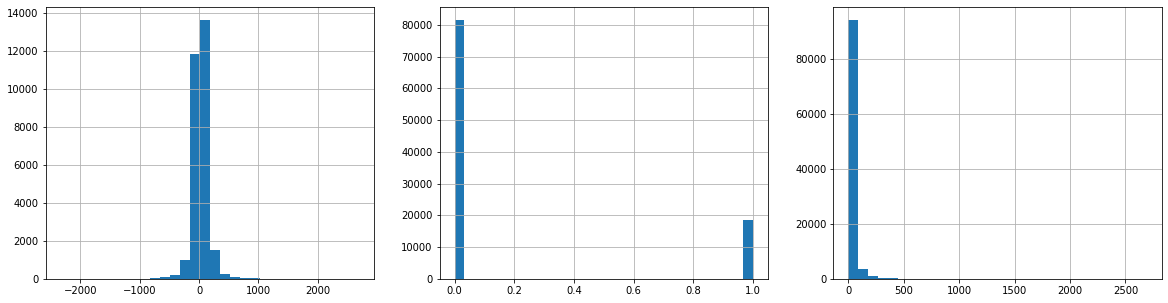

In [31]:
import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
df.inc_sales.hist(figsize=(20,5), bins=30)
# plt.figure()
plt.subplot(1, 3, 2)
df.Converted.hist(bins=30)
# plt.figure()
plt.subplot(1, 3, 3)
df.Converted_weighted.hist(bins=30)

<AxesSubplot:>

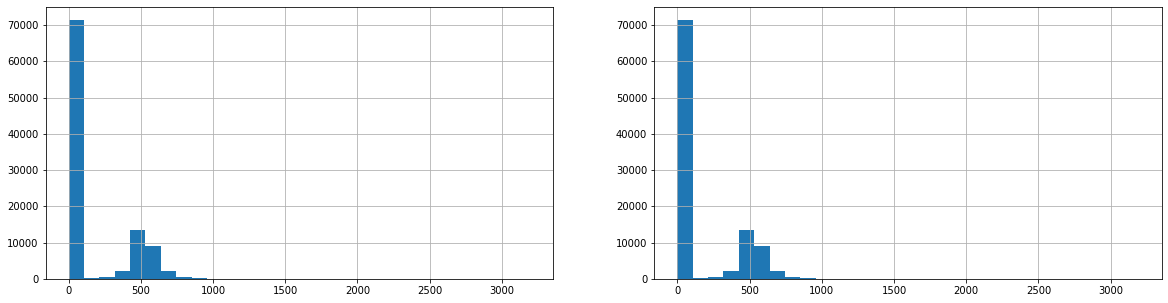

In [32]:
# adding a constant, cupping at 0 and rounding
plt.subplot(1, 2, 1)
df.loc[:, "Converted_weighted_constant"].hist(bins=30, figsize=(20,5))
plt.subplot(1, 2, 2)
# NANs to 0, these are records with no inc sales
df.loc[:, "Converted_weighted_constant"].hist(bins=30)

In [64]:
np.percentile(df.inc_sales[df.inc_sales.notna()], 0.05)

-1146.0499067256935

In [33]:
df.head()

wk_start_date                  crn  inc_sales  \
536432    2021-02-08  1100000000054932982        NaN   
513369    2021-02-08  1100000000039184696        NaN   
951290    2021-02-08  3300000000004169326  -4.181564   
687470    2021-02-08  1100000000093580790        NaN   
599003    2021-02-08  1100000000083301004        NaN   

                                                     path  \
536432                                CAT-4031_email_open   
513369  CAT-4031_email/social/rapp_activation > CAT-41...   
951290  CAT-4031_email/social/rapp_activation > CVM-00...   
687470  CAT-4105_email_open > CAT-4105_rw_app_imp > CA...   
599003          CAT-4031_rw_app_imp > CAT-4031_email_open   

                                                    Paths  Converted  \
536432                 start > CAT-4031_email_open > null          0   
513369  start > CAT-4031_email/social/rapp_activation ...          0   
951290  start > CAT-4031_email/social/rapp_activation ...          0   
687470  start > CAT-4105_email_open > CAT-4105_rw_app_...          0   
599003  start > CAT-4031_rw_app_imp > CAT-4031_email_o...          0   

        Converted_weighted  Converted_weighted_constant  
536432                   0                            0  
513369                   0                            0  
951290                   0                          496  
687470                   0                            0  
599003                   0                            0

### Planology format

In [34]:
def cj_to_attribution_df_planology(cj, conversion_col, duplicate=False):
    """
    arguments
        cj - dataframe representing customer journey
        conversion_col - column name of conversions, string
        duplicate - if duplications are needed based on conversions > 0, boolean
    returns
        [dataframe with attribution values, total run time, run time of the attribution, shape of customer journey (including dups)]
    """    
    start_time = time.time()
    
    # extract only needed columns
    cj = cj.loc[:, ["crn", "Paths", conversion_col]]    
    
    # duplication for conversion > 0 if needed
    if duplicate:
        cj_dup = pd.DataFrame([cj.loc[idx]
                               for idx in cj.index 
                               for _ in range(cj.loc[idx][conversion_col])]).reset_index(drop=True)
        cj = pd.concat([cj_dup, cj.loc[cj.loc[:, conversion_col] == 0,:]])
    
    # generate attribution
    start_time_mta = time.time()
    attribution_dict = mta.from_journey(cj)    
    
    # ending timers
    run_time_mta = round((time.time() - start_time_mta), 1)
    run_time = round((time.time() - start_time), 1)
    
    # convert to df
    attribution_df = pd.DataFrame.from_dict(attribution_dict, orient='index',columns=["Attribution"]).sort_index()
    
    return [attribution_df, [run_time, run_time_mta], cj.shape]
    

#### Conversion == inc sales > 0

In [35]:
attribution = cj_to_attribution_df_planology(df, "Converted")
attribution

[                                       Attribution
 CAT-4031_email/social/rapp_activation     0.095393
 CAT-4031_email/social/rapp_redemption     0.027615
 CAT-4031_email_clk                        0.025732
 CAT-4031_email_open                       0.052593
 CAT-4031_rw_app_clk                       0.021552
 CAT-4031_rw_app_imp                       0.041497
 CAT-4105_email/social/rapp_activation     0.115630
 CAT-4105_email/social/rapp_redemption     0.089548
 CAT-4105_email_clk                        0.048830
 CAT-4105_email_open                       0.065311
 CAT-4105_rw_app_clk                       0.024060
 CAT-4105_rw_app_imp                       0.048047
 CVM-0007_email/rapp_activation            0.051914
 CVM-0007_email/rapp_redemption            0.035119
 CVM-0007_email_clk                        0.020318
 CVM-0007_email_open                       0.020886
 CVM-0007_rw_app_clk                       0.022076
 CVM-0007_rw_app_imp                       0.030041
 CVM-0007_rw

#### Conversion := positive inc sales dollars

In [36]:
# attribution_weighted = cj_to_attribution_df_planology(df, "Converted_weighted", duplicate=1)
# attribution_weighted

#### Conversion := positive inc sales dollars plus constant

In [37]:
# attribution_weighted_const = cj_to_attribution_df_planology(df, "Converted_weighted_constant", duplicate=1)
# attribution_weighted_const

### Testing new Channel Attribution Format

#### Conversion := inc sales > 0

In [38]:
def convert_to_CA_format(df, conversion_col = "Converted"):
    """
    Massage df into CA format
    arguments
        df - customer journey in planology format
        conversion_col - column name of conversions to be weighted, string
        conversion_col_count - column name of indicator of conversions
    returns
        customer journey in Channel Attribution format, pandas dataframe
    """
    cj_ca = df.loc[:, ["path", conversion_col]]
    cj_ca.loc[:, "conversion_boolean"] = (cj_ca.loc[:, conversion_col] > 0).astype(int)
    cj_ca = cj_ca.groupby("path").agg(['mean', 'count'])

    cj_ca = pd.DataFrame({"path":cj_ca.index,
                          "conversions":cj_ca.loc[:, conversion_col].loc[:, "count"] * cj_ca.loc[:, conversion_col].loc[:, "mean"],
                          "total_conversion_value":cj_ca.loc[:, conversion_col].loc[:, "count"] * cj_ca.loc[:, conversion_col].loc[:, "mean"],
                          "non_conversions":cj_ca.loc[:, "conversion_boolean"].loc[:, "count"] * (1 - cj_ca.loc[:, "conversion_boolean"].loc[:, "mean"])}).reset_index(drop=True)
    cj_ca
    return cj_ca

In [39]:
def cj_to_attribution_df_ca(cj, conversion_col):
    """
    arguments
        cj - dataframe representing customer journey
        conversion_col - column name of conversions, string
        duplicate - if duplications are needed based on conversions > 0, boolean
    returns
        [dataframe with attribution values, total run time, run time of the attribution, shape of customer journey (including dups)]
    """    
    start_time = time.time()
    
    # extract only needed columns
    cj_ca = convert_to_CA_format(cj, conversion_col)    
  
    # generate attribution
    start_time_mta = time.time()
    attribution_dict = mta.ca_from_journey(cj_ca)    
    
    # ending timers
    run_time_mta = round((time.time() - start_time_mta), 1)
    run_time = round((time.time() - start_time), 1)
    
    # convert to df
    attribution_df = attribution_dict.set_index("channel_name").loc[:, ["normalised_conversion_value"]].rename(columns={"normalised_conversion_value":"Attribution_ca"})
    
    return [attribution_df, [run_time, run_time_mta], cj.shape]
    

In [40]:
attribution_ca = cj_to_attribution_df_ca(df, "Converted")

Number of simulations: 100000 - Reaching convergence (wait...): 5.73% > 5.00%
Number of simulations: 150000 - Convergence reached: 4.88% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%


In [41]:
attribution_ca_weighted = cj_to_attribution_df_ca(df, "Converted_weighted")

Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.57%


In [42]:
attribution_ca_weighted_const = cj_to_attribution_df_ca(df, "Converted_weighted_constant")

Number of simulations: 100000 - Convergence reached: 1.42% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.54%


In [43]:
attribution_ca

[                                       Attribution_ca
 channel_name                                         
 CAT-4031_email/social/rapp_activation        0.160818
 CAT-4031_email/social/rapp_redemption        0.016512
 CAT-4031_email_open                          0.071832
 CAT-4031_email_clk                           0.012470
 CAT-4105_rw_app_imp                          0.053470
 CAT-4031_rw_app_imp                          0.041625
 CAT-4105_rw_app_clk                          0.006100
 CAT-4105_email/social/rapp_redemption        0.144827
 CAT-4105_email/social/rapp_activation        0.205043
 CAT-4105_email_open                          0.095483
 CAT-4105_email_clk                           0.059763
 CAT-4031_rw_app_clk                          0.002246
 CVM-3509_rw_app_imp                          0.002422
 CVM-0007_email_open                          0.000807
 CVM-0007_email/rapp_activation               0.068809
 CVM-0007_rw_app_imp                          0.021798
 CVM-0007_

# Results

In [52]:
# uncomment if planology dup
# results = attribution[0].join(attribution_weighted[0], lsuffix='', rsuffix='_weighted').join(attribution_weighted_const[0], lsuffix='', rsuffix='_weighted_const')
# results = results.join(attribution_ca[0], lsuffix='', rsuffix='_ca').join(attribution_ca_weighted[0], lsuffix='', rsuffix='_ca_weighted').join(attribution_ca_weighted_const[0], lsuffix='', rsuffix='_ca_weighted_const')

# uncomment if no planology dup
results = attribution[0].join(attribution_ca[0]).join(attribution_ca_weighted[0], rsuffix='_weighted').join(attribution_ca_weighted_const[0], rsuffix='_weighted_const')

results.loc['Column_Total']= results.sum(numeric_only=True, axis=0)
results

Attribution  Attribution_ca  \
CAT-4031_email/social/rapp_activation     0.095393        0.160818   
CAT-4031_email/social/rapp_redemption     0.027615        0.016512   
CAT-4031_email_clk                        0.025732        0.012470   
CAT-4031_email_open                       0.052593        0.071832   
CAT-4031_rw_app_clk                       0.021552        0.002246   
CAT-4031_rw_app_imp                       0.041497        0.041625   
CAT-4105_email/social/rapp_activation     0.115630        0.205043   
CAT-4105_email/social/rapp_redemption     0.089548        0.144827   
CAT-4105_email_clk                        0.048830        0.059763   
CAT-4105_email_open                       0.065311        0.095483   
CAT-4105_rw_app_clk                       0.024060        0.006100   
CAT-4105_rw_app_imp                       0.048047        0.053470   
CVM-0007_email/rapp_activation            0.051914        0.068809   
CVM-0007_email/rapp_redemption            0.035119        0.031759   
CVM-0007_email_clk                        0.020318        0.000000   
CVM-0007_email_open                       0.020886        0.000807   
CVM-0007_rw_app_clk                       0.022076        0.003319   
CVM-0007_rw_app_imp                       0.030041        0.021798   
CVM-0007_rw_app_push_clk                  0.020415        0.000359   
CVM-0007_rw_app_push_imp                  0.020309        0.000090   
CVM-3509_email_clk                        0.020307        0.000000   
CVM-3509_email_open                       0.020555        0.000449   
CVM-3509_rw_app_clk                       0.020341        0.000000   
CVM-3509_rw_app_imp                       0.021278        0.002422   
CVM-3509_rw_app_push_clk                  0.020326        0.000000   
CVM-3509_rw_app_push_imp                  0.020308        0.000000   
Column_Total                              1.000000        1.000000   

                                       Attribution_ca_weighted  \
CAT-4031_email/social/rapp_activation                 0.157930   
CAT-4031_email/social/rapp_redemption                 0.026100   
CAT-4031_email_clk                                    0.008897   
CAT-4031_email_open                                   0.052385   
CAT-4031_rw_app_clk                                   0.002326   
CAT-4031_rw_app_imp                                   0.039833   
CAT-4105_email/social/rapp_activation                 0.184030   
CAT-4105_email/social/rapp_redemption                 0.170703   
CAT-4105_email_clk                                    0.053492   
CAT-4105_email_open                                   0.080036   
CAT-4105_rw_app_clk                                   0.008565   
CAT-4105_rw_app_imp                                   0.059694   
CVM-0007_email/rapp_activation                        0.078559   
CVM-0007_email/rapp_redemption                        0.052828   
CVM-0007_email_clk                                    0.000037   
CVM-0007_email_open                                   0.000554   
CVM-0007_rw_app_clk                                   0.003322   
CVM-0007_rw_app_imp                                   0.017055   
CVM-0007_rw_app_push_clk                              0.000258   
CVM-0007_rw_app_push_imp                              0.000000   
CVM-3509_email_clk                                    0.000000   
CVM-3509_email_open                                   0.000369   
CVM-3509_rw_app_clk                                   0.000037   
CVM-3509_rw_app_imp                                   0.002990   
CVM-3509_rw_app_push_clk                              0.000000   
CVM-3509_rw_app_push_imp                              0.000000   
Column_Total                                          1.000000   

                                       Attribution_ca_weighted_const  
CAT-4031_email/social/rapp_activation                       0.157005  
CAT-4031_email/social/rapp_redemption                       0.028693  
CAT-4031_email_c

# Speed testing

In [17]:
df = pd.read_csv('gs://wx-personal/AndrewLau/nash/MC_POC/MC_input_with_act_redemp.csv')
df.loc[:, "Converted_weighted_constant"] = round(np.maximum(0, df['inc_sales'] + 500), 0)
df.loc[:, "Converted_weighted_constant"] = df.loc[:, "Converted_weighted_constant"].fillna(0).astype("int64")
df

wk_start_date                  crn  inc_sales  \
0         2021-02-08  1000000000000000016 -28.388906   
1         2021-02-08  1000000000000000022        NaN   
2         2021-02-08  1000000000000000044        NaN   
3         2021-02-08  1000000000000000048        NaN   
4         2021-02-08  1000000000000000076   7.078295   
...              ...                  ...        ...   
961716    2021-02-08  3300000000004893190        NaN   
961717    2021-02-08  3300000000004893373        NaN   
961718    2021-02-08  3300000000004893716        NaN   
961719    2021-02-08  3300000000004893746        NaN   
961720    2021-02-08  3300000000004894024        NaN   

                                                     path  \
0       CAT-4031_email/social/rapp_activation > CVM-00...   
1                   CAT-4031_email/social/rapp_activation   
2       CAT-4031_email/social/rapp_activation > CAT-41...   
3       CAT-4031_email_open > CAT-4031_email_clk > CAT...   
4       CAT-4105_rw_app_imp > CAT-4105_email/social/ra...   
...                                                   ...   
961716          CVM-3509_rw_app_imp > CAT-4105_rw_app_imp   
961717                                CAT-4105_rw_app_imp   
961718                                CAT-4105_rw_app_imp   
961719                                CAT-4105_rw_app_imp   
961720                                CVM-0007_rw_app_imp   

                                                    Paths  Converted  \
0       start > CAT-4031_email/social/rapp_activation ...          0   
1       start > CAT-4031_email/social/rapp_activation ...          0   
2       start > CAT-4031_email/social/rapp_activation ...          0   
3       start > CAT-4031_email_open > CAT-4031_email_c...          0   
4       start > CAT-4105_rw_app_imp > CAT-4105_email/s...          1   
...                                                   ...        ...   
961716  start > CVM-3509_rw_app_imp > CAT-4105_rw_app_...          0   
961717                 start > CAT-4105_rw_app_imp > null          0   
961718                 start > CAT-4105_rw_app_imp > null          0   
961719                 start > CAT-4105_rw_app_imp > null          0   
961720                 start > CVM-0007_rw_app_imp > null          0   

        Converted_weighted  Converted_weighted_constant  
0                        0                          472  
1                        0                            0  
2                        0                            0  
3                        0                            0  
4                        7                          507  
...                    ...                          ...  
961716                   0                            0  
961717                   0                            0  
961718                   0                            0  
961719                   0                            0  
961720                   0                            0  

[961721 rows x 8 columns]

In [18]:
def speed_test(df, samples, seed=123, planology_dup=False):
    df = df.sample(n=samples, random_state=seed)  # random sample for testing
    
    if planology_dup:
        attribution_weighted = cj_to_attribution_df_planology(df, "Converted_weighted", duplicate=1)
        attribution_weighted_const = cj_to_attribution_df_planology(df, "Converted_weighted_constant", duplicate=1)

    attribution = cj_to_attribution_df_planology(df, "Converted")
    attribution_ca = cj_to_attribution_df_ca(df, "Converted")
    attribution_ca_weighted = cj_to_attribution_df_ca(df, "Converted_weighted")
    attribution_ca_weighted_const = cj_to_attribution_df_ca(df, "Converted_weighted_constant")
    
    if planology_dup:
        return pd.DataFrame({"index":["Runtime total, runtime MTA", "Dataframe shape"], "Planology": attribution[1:]
                             , "Planology weighted": attribution_weighted[1:], "Planology weighted constant": attribution_weighted_const[1:]
                             , "CA": attribution_ca[1:], "CA weighted": attribution_ca_weighted[1:], "CA weighted constant": attribution_ca_weighted_const[1:]
                            }).set_index("index")
    else:
        return pd.DataFrame({"index":["Runtime total, runtime MTA", "Dataframe shape"], "Planology": attribution[1:]
                             , "CA": attribution_ca[1:], "CA weighted": attribution_ca_weighted[1:], "CA weighted constant": attribution_ca_weighted_const[1:]
                            }).set_index("index")

In [19]:
results_speed_1k = speed_test(df, 1_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.48% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.96%
Number of simulations: 100000 - Convergence reached: 1.46% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.49%
Number of simulations: 100000 - Convergence reached: 1.68% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.16%


In [20]:
results_speed_5k = speed_test(df, 5_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.36% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.96%
Number of simulations: 100000 - Convergence reached: 1.83% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.42%
Number of simulations: 100000 - Convergence reached: 1.70% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.25%


In [21]:
results_speed_10k = speed_test(df, 10_000, planology_dup=True)

Number of simulations: 100000 - Convergence reached: 4.39% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 1.79% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.44%
Number of simulations: 100000 - Convergence reached: 1.50% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.30%


In [22]:
results_speed_25k = speed_test(df, 25_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.76% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 2.09% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.34%
Number of simulations: 100000 - Convergence reached: 1.63% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.34%


In [23]:
results_speed_50k = speed_test(df, 50_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.86% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.97%
Number of simulations: 100000 - Convergence reached: 1.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.35%
Number of simulations: 100000 - Convergence reached: 1.78% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (13) is reached: 99.33%


In [24]:
results_speed_100k = speed_test(df, 100_000, planology_dup=False)

Number of simulations: 100000 - Reaching convergence (wait...): 5.73% > 5.00%
Number of simulations: 150000 - Convergence reached: 4.88% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.57%
Number of simulations: 100000 - Convergence reached: 1.42% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.54%


In [25]:
results_speed_250k = speed_test(df, 250_000, planology_dup=False)

Number of simulations: 100000 - Reaching convergence (wait...): 5.67% > 5.00%
Number of simulations: 150000 - Convergence reached: 4.95% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.56% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.53%
Number of simulations: 100000 - Convergence reached: 1.85% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.50%


In [26]:
results_speed_500k = speed_test(df, 500_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.13% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.81% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.54%
Number of simulations: 100000 - Convergence reached: 1.75% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (14) is reached: 99.56%


In [27]:
results_speed_750k = speed_test(df, 750_000, planology_dup=False)

Number of simulations: 100000 - Convergence reached: 4.16% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.98%
Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.72%
Number of simulations: 100000 - Convergence reached: 1.98% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.70%


In [28]:
results_speed_1k.append(results_speed_5k).append(results_speed_10k).append(results_speed_25k).append(results_speed_50k).append(results_speed_100k).append(results_speed_250k).append(results_speed_500k).append(results_speed_750k)

Planology Planology weighted  \
index                                                           
Runtime total, runtime MTA      [0.8, 0.7]         [6.5, 3.7]   
Dataframe shape                  (1000, 3)         (14174, 3)   
Runtime total, runtime MTA      [2.2, 2.2]       [37.9, 22.3]   
Dataframe shape                  (5000, 3)         (80660, 3)   
Runtime total, runtime MTA      [3.7, 3.7]       [77.3, 46.7]   
Dataframe shape                 (10000, 3)        (159288, 3)   
Runtime total, runtime MTA      [8.5, 8.5]                NaN   
Dataframe shape                 (25000, 3)                NaN   
Runtime total, runtime MTA    [17.4, 17.4]                NaN   
Dataframe shape                 (50000, 3)                NaN   
Runtime total, runtime MTA    [37.0, 37.0]                NaN   
Dataframe shape                (100000, 3)                NaN   
Runtime total, runtime MTA    [93.6, 93.6]                NaN   
Dataframe shape                (250000, 3)                NaN   
Runtime total, runtime MTA  [186.1, 186.1]                NaN   
Dataframe shape                (500000, 3)                NaN   
Runtime total, runtime MTA  [282.8, 282.8]                NaN   
Dataframe shape                (750000, 3)                NaN   

                           Planology weighted constant           CA  \
index                                                                 
Runtime total, runtime MTA                [59.8, 32.5]   [0.1, 0.0]   
Dataframe shape                            (142281, 3)    (1000, 8)   
Runtime total, runtime MTA              [345.2, 199.8]   [0.1, 0.1]   
Dataframe shape                            (761355, 3)    (5000, 8)   
Runtime total, runtime MTA              [728.2, 432.7]   [0.1, 0.1]   
Dataframe shape                           (1554313, 3)   (10000, 8)   
Runtime total, runtime MTA                         NaN   [0.1, 0.1]   
Dataframe shape                                    NaN   (25000, 8)   
Runtime total, runtime MTA                         NaN   [0.2, 0.1]   
Dataframe shape                                    NaN   (50000, 8)   
Runtime total, runtime MTA                         NaN   [0.2, 0.1]   
Dataframe shape                                    NaN  (100000, 8)   
Runtime total, runtime MTA                         NaN   [0.3, 0.2]   
Dataframe shape                                    NaN  (250000, 8)   
Runtime total, runtime MTA                         NaN   [0.4, 0.1]   
Dataframe shape                                    NaN  (500000, 8)   
Runtime total, runtime MTA                         NaN   [0.5, 0.1]   
Dataframe shape                                    NaN  (750000, 8)   

                            CA weighted CA weighted constant  
index                                                         
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape               (1000, 8)            (1000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape               (5000, 8)            (5000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (10000, 8)           (10000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (25000, 8)           (25000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape              (50000, 8)           (50000, 8)  
Runtime total, runtime MTA   [0.1, 0.1]           [0.1, 0.1]  
Dataframe shape             (100000, 8)          (100000, 8)  
Runtime total, runtime MTA   [0.2, 0.1]           [0.2, 0.1]  
Dataframe shape             (250000, 8)          (250000, 8)  
Runtime total, runtime MTA   [0.3, 0.1]           [0.3, 0.1]  
Dataframe shape             (500000, 8)          (500000, 8)  
Runtime total, runtime MTA   [0.4, 0.2]           [0.4, 0.2]  
Dataframe shape             (750000, 8)          (750000, 8)